[Solution of the Poisson equation within the domain \[0,1\]](https://github.com/nithinadidela/poisson-eq-FDM/blob/master/Thomas-TDMA.py)

## EXACT SOLUTION

In [10]:
import numpy as np
import math as m
import scipy.misc as sm
from numba import jit, f8

@jit(f8(f8, f8, f8, f8))
def P0(z, Bi, δ, Gr):
    p1 = -2*Bi*(δ**2)*(z**4)/((1+Bi)*m.factorial(4))
    p2 = 2*(δ**2)*(z**3)/((1+Bi)*m.factorial(3))
    p3 = ((δ**2)*Bi*(Bi+3)-3*Bi*(Bi+1))*(z**2)/(12*((Bi+1)**2))
    p4 = ((3*(Bi+1)-(δ**2)*(Bi+3))/(6*((Bi+1)**2)) - (δ**2)*(4*Bi+15)/(60*(1+Bi)))*z
    return p1 + p2 + p3 + p4 + 1

@jit(f8(f8, f8, f8, f8))
def P11(z, Bi, δ, Gr):
    p1 = Bi*(z**2)/((1+Bi)*m.factorial(2))
    p2 = -z/(1+Bi)
    return p1+p2

@jit(f8(f8, f8, f8, f8))
def T0(z, Bi, δ, Gr):
    t1 = -(Bi*(δ**2)*(z**3))/((1+Bi)*m.factorial(3))
    t2 = ((δ**2)*(z**2))/((1+Bi)*m.factorial(2))
    t3 = ((δ**2)*Bi*(Bi+3)-3*Bi*(Bi+1))*z/(6*((Bi+1)**2))
    t4 = (3*(Bi+1)-(δ**2)*(Bi+3))/(6*((Bi+1)**2)) 
    return t1 + t2 + t3 + t4

def dP0(z, Bi, δ, Gr):
    return sm.derivative(lambda z: P0(z, Bi, δ, Gr), z, dx=0.001)

In [11]:
import matplotlib.pyplot as plt
from numba import jit, f8

class Parameters:
    def __init__(self, Bi, δ, Gr):
        self.Bi = Bi
        self.δ = δ
        self.Gr = Gr

def PrintExactSolution(exact_solution, parameters):
    l=1.0			     # length of the domain
    n=100			     # number of mesh divisions (for first question)	
    del_z=l/(n-1)		 # mesh size

    z_values = np.zeros(n)
    e_values = np.zeros(n)

    z_values[0] = -1
    e_values[0] = exact_solution(z_values[0], parameters.Bi, parameters.δ, parameters.Gr)

    for i in range(1, len(z_values)):
        z_values[i]=z_values[i-1]+del_z
        e_values[i]=exact_solution(z_values[i], parameters.Bi, parameters.δ, parameters.Gr)

    plt.plot(z_values, e_values, color='blue', markerfacecolor='blue', linestyle='dashed')
    plt.title('Exact solution (Gr={})'.format(parameters.Gr))
    plt.xlabel('Domain')
    plt.ylabel('Exact Solution')
    plt.show()

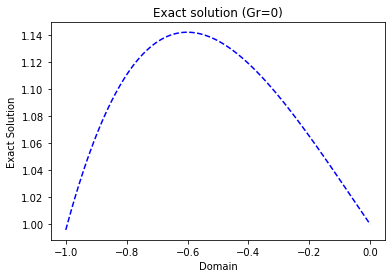

In [12]:
PrintExactSolution(P0, Parameters(Bi=2, δ=1.5, Gr=0))

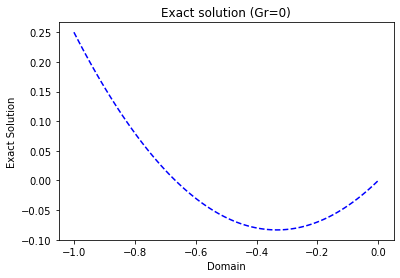

In [13]:
PrintExactSolution(P11, Parameters(Bi=-3, δ=0, Gr=0))

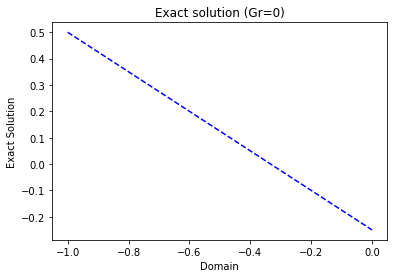

In [14]:
PrintExactSolution(T0, Parameters(Bi=-3, δ=0.01, Gr=0))

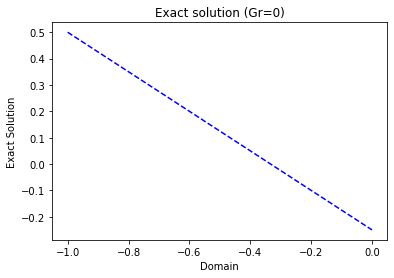

In [15]:
PrintExactSolution(dP0, Parameters(Bi=-3, δ=0.01, Gr=0))

## NUMERICAL SOLUTION

In [7]:
import numba as nb
import math as mt

@nb.jit(f8(nb.f8, nb.f8, nb.f8, nb.f8, nb.f8))
def CalcInitialConditions(z, Bi, δ, Gr, ω):
    C1 = (dP0(z, Bi, δ, Gr) - T0(z, Bi, δ, Gr)) / (δ**2)

    a = 1
    b = -Gr*ω
    c = -1
    D = ((b**2)-4*a*c)/2*a

    k1 = (-b + mt.sqrt(D))/2*a
    k2 = (-b - mt.sqrt(D))/2*a

    λ1 = mt.exp(-k2)/(mt.exp(-k2) - mt.exp(-k1))
    λ2 = -mt.exp(-k1)/(mt.exp(-k2) - mt.exp(-k1))

    return λ1*mt.exp(k1*z) - λ2*mt.exp(k2*z)

In [8]:
@nb.jit(nb.types.Tuple((nb.f8[:], nb.f8[:]))(nb.f8, nb.f8, nb.f8))
def CalcFirstEquation(δ, Bi, Gr):   
    l=1.0
    n=100
    h=l/(n-1)

    τ = 1e-4
    ε = 1e-5

    z=np.zeros(n)
    α = np.zeros(n+1)
    β = np.zeros(n+1)
    ω = np.zeros(n)

    z[0] = -1
    ω[0] = 0 #CalcInitialConditions(z[0], Bi, δ, Gr, 0.5)

    α[0] = 0
    β[0] = 0

    for i in range(1, n):
        z[i]=i*h + z[0]

        ω_t1 = ω[i-1]
        ω_t2 = 0

        while True:
            C1 = dP0(z[i], Bi, δ, Gr) - T0(z[i], Bi, δ, Gr)

            Ai = ((δ**2)/(h**2) + (Gr*(δ**2)*ω_t1/(2*h)))
            Bi = -2*(δ**2)/(h**2) - 1/τ
            Ci = ((δ**2)/(h**2) - (Gr*(δ**2)*ω_t1/(2*h)))
            Fi =  C1 - ω_t1/τ

            α[i+1] = -Ci/(α[i]*Ai + Bi)
            β[i+1] = (Fi-Ai*β[i])/(α[i]*Ai + Bi)
            ω_t2 = α[i+1]*ω_t1 + β[i+1]

            if abs(ω_t1 - ω_t2) <= ε:
                break

            ω_t1 = ω_t2

        ω[i] = ω_t2
    return z, ω

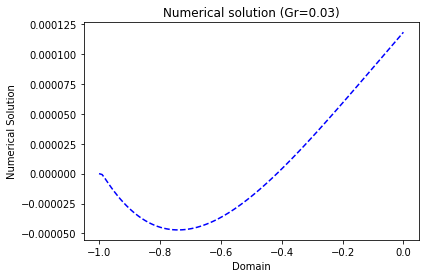

In [9]:
δ=1
Bi=-3
Gr=0.03

z, ω = CalcFirstEquation(δ, Bi, Gr)

plt.plot(z, ω, color='blue', markerfacecolor='blue', linestyle='dashed')
plt.title('Numerical solution (Gr={})'.format(Gr))
plt.xlabel('Domain')
plt.ylabel('Numerical Solution')
plt.show()

In [ ]:
CalcInitialConditions(δ=0.01, Bi=2, Gr=0.03, z=-1, ω=0)

1.3028923053984047

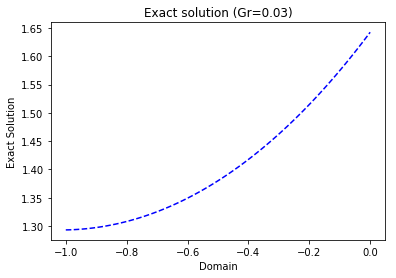

In [ ]:
w_i = lambda z, Bi, δ, Gr: CalcInitialConditions(z, Bi, δ, Gr, 0.5)
PrintExactSolution(w_i, Parameters(Bi=2, δ=0.01, Gr=0.03))

In [49]:
def FindSolution(z, v_initial, A_func, B_func, C_func, F_func):   
    ε = 1e-5

    α = np.zeros(n+1)
    β = np.zeros(n+1)

    v = np.zeros(n)
    v[0] = v_initial

    α[0] = 0
    β[0] = 0

    for i in range(1, n):
        v_t1 = v[i-1]
        v_t2 = 0

        while True:
            Ai = A_func(i, v_t1)
            Bi = B_func(i, v_t1)
            Ci = C_func(i, v_t1)
            Fi = F_func(i, v_t1)

            α[i+1] = -Ci/(α[i]*Ai + Bi)
            β[i+1] = (Fi-Ai*β[i])/(α[i]*Ai + Bi)
            v_t2 = α[i+1]*v_t1 + β[i+1]

            if abs(v_t1 - v_t2) <= ε:
                break

            v_t1 = v_t2

        v[i] = v_t2

        if i % 10 == 0:
            print('-- {} value: {}'.format(i, v[i]))
    return v

def PrintSolution(z, v, title):
    plt.plot(z, v, color='blue', markerfacecolor='blue', linestyle='dashed')
    plt.title(title)
    plt.xlabel('Domain')
    plt.ylabel('Numerical Solution')
    plt.show()

## Generate 'z' values

In [53]:
import numpy as np

z_left_border = -1.0
z_right_border = 0.0

n=100
h=(z_right_border - z_left_border)/(n-1)

z = np.zeros(n)
for i in range(0, n):
    z[i]=z_left_border + i*h

print(z)

[-1.         -0.98989899 -0.97979798 -0.96969697 -0.95959596 -0.94949495
 -0.93939394 -0.92929293 -0.91919192 -0.90909091 -0.8989899  -0.88888889
 -0.87878788 -0.86868687 -0.85858586 -0.84848485 -0.83838384 -0.82828283
 -0.81818182 -0.80808081 -0.7979798  -0.78787879 -0.77777778 -0.76767677
 -0.75757576 -0.74747475 -0.73737374 -0.72727273 -0.71717172 -0.70707071
 -0.6969697  -0.68686869 -0.67676768 -0.66666667 -0.65656566 -0.64646465
 -0.63636364 -0.62626263 -0.61616162 -0.60606061 -0.5959596  -0.58585859
 -0.57575758 -0.56565657 -0.55555556 -0.54545455 -0.53535354 -0.52525253
 -0.51515152 -0.50505051 -0.49494949 -0.48484848 -0.47474747 -0.46464646
 -0.45454545 -0.44444444 -0.43434343 -0.42424242 -0.41414141 -0.4040404
 -0.39393939 -0.38383838 -0.37373737 -0.36363636 -0.35353535 -0.34343434
 -0.33333333 -0.32323232 -0.31313131 -0.3030303  -0.29292929 -0.28282828
 -0.27272727 -0.26262626 -0.25252525 -0.24242424 -0.23232323 -0.22222222
 -0.21212121 -0.2020202  -0.19191919 -0.18181818 -0.

## Set parameters

In [64]:
τ = 1e-6

δ=1
Bi=-3
Gr=0.03

## Calculate 'ω'

-- 10 value: -1.274979260856377e-07
-- 20 value: -1.0275742280592862e-07
-- 30 value: -2.356311465090244e-09
-- 40 value: 1.1228802810868007e-07
-- 50 value: 1.9492296662146888e-07
-- 60 value: 2.1446062531413481e-07
-- 70 value: 1.549778759615473e-07
-- 80 value: 1.5716340874002274e-08
-- 90 value: -1.8891760710506555e-07


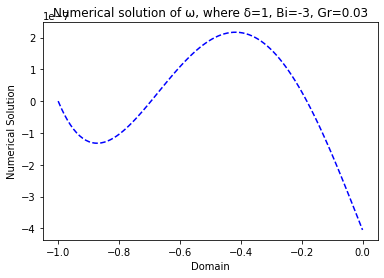

In [65]:
ω_initial = 0

C1_func = lambda i: dP0(z[i], Bi, δ, Gr) - T0(z[i], Bi, δ, Gr)

A_func = lambda i, v_t1: ((δ**2)/(h**2) + (Gr*(δ**2)*v_t1/(2*h)))
B_func = lambda i, v_t1: -2*(δ**2)/(h**2) - 1/τ
C_func = lambda i, v_t1: ((δ**2)/(h**2) - (Gr*(δ**2)*v_t1/(2*h)))
F_func = lambda i, v_t1: C1_func(i) - v_t1/τ

ω = FindSolution(z, ω_initial, A_func, B_func, C_func, F_func)
PrintSolution(z, ω, 'Numerical solution of ω, where δ={}, Bi={}, Gr={}'.format(δ, Bi, Gr))

## Calculate 'u'

-- 10 value: -1.8999396487531557e-06
-- 20 value: -2.800456409914669e-06
-- 30 value: -2.9440372882921436e-06
-- 40 value: -2.5502494638988037e-06
-- 50 value: -1.8178663083060181e-06
-- 60 value: -9.268366337334584e-07
-- 70 value: -4.006744710720228e-08
-- 80 value: 6.949621291583996e-07
-- 90 value: 1.1447397805315345e-06


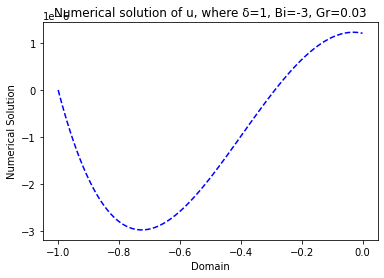

In [66]:
u_initial = 0

C2_func = lambda i: P11(z[i], Bi, δ, Gr)

A_func = lambda i, v_t1: -(1/(h**2) + (Gr*ω[i]/(2*h)))
B_func = lambda i, v_t1: 1/(h**2) + Gr*v_t1 - 1/τ
C_func = lambda i, v_t1: -(1/(h**2) - (Gr*ω[i]/(2*h)))
F_func = lambda i, v_t1: C2_func(i) - v_t1/τ

u = FindSolution(z, u_initial, A_func, B_func, C_func, F_func)
PrintSolution(z, u, 'Numerical solution of u, where δ={}, Bi={}, Gr={}'.format(δ, Bi, Gr))